# CS 370 101 Assignment 3<br>
Eugene Casuple

## Imports

In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import torch
import torchvision
from torch import nn
from torchvision import transforms

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

url = "https://www.youtube.com/watch?v=vUnuDTVHwGE"

Using cache found in /home/vscode/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vscode/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vscode/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


youtube-dl is a backend used by Pafy to download youtube videos. As this dependency is dead and unmantained, we have to use a fork that uses yt-dlp.

In [2]:
#%pip install git+https://github.com/henkmet/pafy.git
import pafy

helper function; converts yt link to OpenCV VideoCapture object

In [3]:
def get_youtube_cap(url):
    play = pafy.new(url).streams[-1] # we will take the lowest quality stream
    assert play is not None # makes sure we get an error if the video failed to load
    return cv2.VideoCapture(play.url)

get pretrained COCO model and set to evaluation mode

In [4]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1').eval().to(device)

preview frame

In [ ]:

cap = get_youtube_cap(url)

ret, frame = cap.read()

cap.release()

plt.imshow(frame[:,:,::-1]) # OpenCV uses BGR, whereas matplotlib uses RGB
plt.show()

IndexError: index 100 is out of bounds for axis 2 with size 3

In [ ]:
class ObjectDetectionPipeline:
    def __init__(self, threshold=0.5, device="cuda", cmap_name="tab10_r"):
        # First we need a Transform object to turn numpy arrays to normalised tensors.
        # We are using an SSD300 model that requires 300x300 images.
        # The normalisation values are standard for pretrained pytorch models.
        self.tfms = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Next we need a model. We're setting it to evaluation mode and sending it to the correct device.
        # We get some speedup from the gpu but not as much as we could.
        # A more efficient way to do this would be to collect frames to a buffer,
        # run them through the network as a batch, then output them one by one
        self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd').eval().to(device)

        # Stop the network from keeping gradients.
        # It's not required but it gives some speedup / reduces memory use.
        for param in self.model.parameters():
            param.requires_grad = False


        self.device = device
        self.threshold = threshold # Confidence threshold for displaying boxes.
        self.cmap = cm.get_cmap(cmap_name) # colour map
        self.classes_to_labels = utils.get_coco_object_dictionary()


    @staticmethod
    def _crop_img(img):
        """Crop an image or batch of images to square"""
        if len(img.shape) == 3:
            y = img.shape[0]
            x = img.shape[1]
        elif len(img.shape) == 4:
            y = img.shape[1]
            x = img.shape[2]
        else:
            raise ValueError(f"Image shape: {img.shape} invalid")

        out_size = min((y, x))
        startx = x // 2 - out_size // 2
        starty = y // 2 - out_size // 2

        if len(img.shape) == 3:
            return img[starty:starty+out_size, startx:startx+out_size]
        elif len(img.shape) == 4:
            return img[:, starty:starty+out_size, startx:startx+out_size]

    def _plot_boxes(self, output_img, labels, boxes):
        """Plot boxes on an image"""
        for label, (x1, y1, x2, y2) in zip(labels, boxes):
            if (x2 - x1) * (y2 - y1) < 0.25:
                # The model seems to output some large boxes that we know cannot be possible.
                # This is a simple rule to remove them.

                x1 = int(x1*output_img.shape[1])
                y1 = int(y1*output_img.shape[0])
                x2 = int(x2*output_img.shape[1])
                y2 = int(y2*output_img.shape[0])

                rgba = self.cmap(label)
                bgr = rgba[2]*255, rgba[1]*255, rgba[0]*255
                cv2.rectangle(output_img, (x1, y1), (x2, y2), bgr, 2)
                cv2.putText(output_img, self.classes_to_labels[label - 1], (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)

        return output_img

    def __call__(self, img):
        """
        Now the call method This takes a raw frame from opencv finds the boxes and draws on it.
        """
        if type(img) == np.ndarray:
            # single image case

            # First convert the image to a tensor, reverse the channels, unsqueeze and send to the right device.
            img_tens = self.tfms(Image.fromarray(img[:,:,::-1])).unsqueeze(0).to(self.device)

            # Run the tensor through the network.
            # We'll use NVIDIAs utils to decode.
            results = utils.decode_results(self.model(img_tens))
            boxes, labels, conf = utils.pick_best(results[0], self.threshold)

            # Crop the image to match what we've been predicting on.
            output_img = self._crop_img(img)

            return self._plot_boxes(output_img, labels, boxes)

        elif type(img) == list:
            # batch case
            if len(img) == 0:
                # Catch empty batch case
                return None

            tens_batch = torch.cat([self.tfms(Image.fromarray(x[:,:,::-1])).unsqueeze(0) for x in img]).to(self.device)
            results = utils.decode_results(self.model(tens_batch))

            output_imgs = []
            for im, result in zip(img, results):
                boxes, labels, conf = utils.pick_best(result, self.threshold)
                output_imgs.append(self._plot_boxes(self._crop_img(im), labels, boxes))

            return output_imgs

        else:
            raise TypeError(f"Type {type(img)} not understood")

Apply object detection to frame 1

Using cache found in /home/vscode/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/tmp/ipykernel_18134/3414779586.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.cmap = cm.get_cmap(cmap_name) # colour map


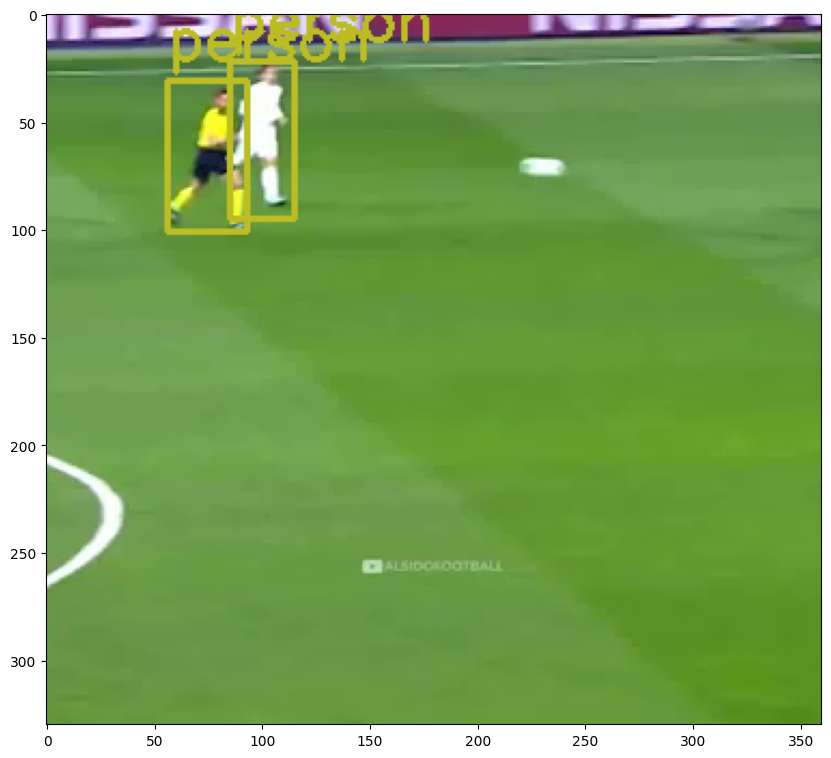

In [ ]:
obj_detect = ObjectDetectionPipeline(device="cuda", threshold=0.5)

plt.figure(figsize=(10,10))
plt.imshow(obj_detect(frame)[:,:,::-1])
plt.show()

Apply object detection to video

In [15]:
batch_size = 16

cap = get_youtube_cap(url)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

size = min([width, height])

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out = cv2.VideoWriter("out.avi", fourcc, 20, (size, size))

obj_detect = ObjectDetectionPipeline(device="cuda", threshold=0.5)

exit_flag = True
while exit_flag:
    batch_inputs = []
    for _ in range(batch_size):
        ret, frame = cap.read()
        if ret:
            batch_inputs.append(frame)
        else:
            exit_flag = False
            break

    outputs = obj_detect(batch_inputs)
    if outputs is not None:
        for output in outputs:
            out.write(output)
    else:
        exit_flag = False

cap.release()

Using cache found in /home/vscode/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vscode/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Detection/SSD/ssd/entrypoints.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open 